In [1]:
from pyflann import *
import numpy as np
import os
import imageio
import time

import sys
import torch
import pdb
from operator import itemgetter
sys.path.append('./')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import tqdm
from pattern_generator import Pattern_Generator_grid

%matplotlib inline

(-0.5, 50.5, 50.5, -0.5)

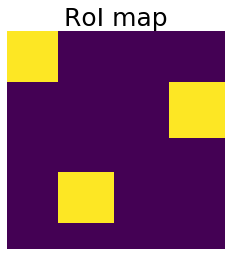

In [2]:
M = 50
weight = np.zeros((M+1,M+1))
weight[:M//4, :M//4] = 10.0
weight[M//4:M//2, -M//4:] = 10.0
weight[2*M//3:(2*M//3+M//4), M//4:M//2] = 10.0
plt.imshow(weight)
plt.title('RoI map', fontsize = 25.0)
plt.axis('off')

In [3]:
frequencies = 5
samples = 200

class coverage_loss_weight:
    def __init__(self):
        self.flann = FLANN()
        
    def set_weight(self, weight):
        self.weight = torch.from_numpy(weight[weight > 0]).float()
        self.x0, self.y0 = np.meshgrid((np.arange(M+1) - M/2)/(M/2), \
                             (np.arange(M+1) - M/2)/(M/2))
        self.x0 = self.x0[weight > 0]
        self.y0 = self.y0[weight > 0]

        self.pix_grid = np.c_[self.x0.ravel(), self.y0.ravel()].astype(np.float32)
        self.x0 = torch.from_numpy(self.x0).float()
        self.y0 = torch.from_numpy(self.y0).float()
    
    def loss_weight(self, grid_x, grid_y):
        loss = 0
        grids = np.concatenate((grid_x[0].unsqueeze(-1).detach().numpy(), \
                                grid_y[0].unsqueeze(-1).detach().numpy()), axis = 1)
        closest_idx, closest_dis = self.flann.nn(\
            grids, self.pix_grid, 1, algorithm="kmeans", branching=32, iterations=7, checks=16)
        loss_mask = torch.from_numpy(1 - (np.sqrt(closest_dis) <= 1/M)).float()
        weight = self.weight*loss_mask
        loss += torch.sum(weight*(torch.abs(self.x0 - grid_x[0, closest_idx]) + \
                                  torch.abs(self.y0 - grid_y[0, closest_idx])))
        return loss/frequencies

Text(0, 0.5, 'normalized loss')

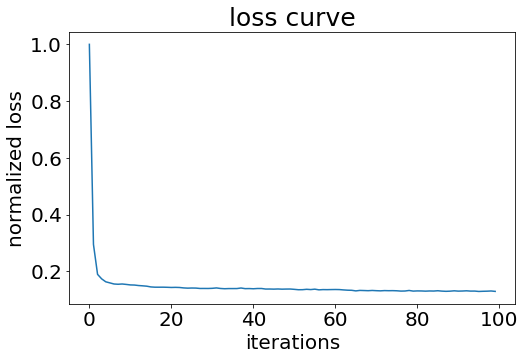

In [7]:
pg = Pattern_Generator_grid(samples, frequencies)
pg.train()
optimizer = torch.optim.SGD(itemgetter(*pg.train_params)(pg.__dict__), lr=1e-3)
coverage_loss = coverage_loss_weight()
coverage_loss.set_weight(weight)

Niter = 100
loss_curve = []
for ii in np.arange(Niter):
    grid_x, grid_y = pg()
    loss = coverage_loss.loss_weight(grid_x, grid_y)
    loss_curve.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

loss_curve = loss_curve/np.max(loss_curve)
fig, ax = plt.subplots(1,1,figsize = (8,5))
plt.plot(loss_curve)
plt.title('loss curve', fontsize = 25.0)
ax.tick_params(axis='x', labelsize = 20.0)
ax.tick_params(axis='y', labelsize = 20.0)
plt.xlabel('iterations', fontsize = 20.0)
plt.ylabel('normalized loss', fontsize = 20.0)

In [8]:
vis_samples = 500
with torch.no_grad():
    pg1 = Pattern_Generator_grid(vis_samples, frequencies)
    pg1.alpha = pg.alpha.clone()
    pg1.beta = pg.beta.clone()
    pg1.gamma = pg.gamma.clone()
    pg1.delta = pg.delta.clone()

    grid_x1, grid_y1 = pg1()

Text(0.5, 1.0, 'Optimized Pattern')

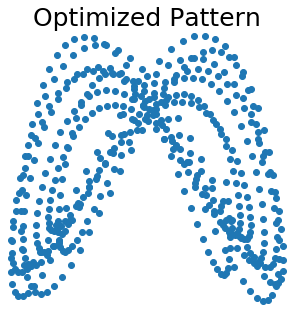

In [9]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
plt.scatter(grid_x1[0].detach().numpy(), grid_y1[0].detach().numpy())
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
plt.axis('off')
plt.title('Optimized Pattern', fontsize = 25.0)